## 課題２
あなたはECサイトを運営する会社で注文システムの関連業務を担当しています。<br>
あるとき 上司より、こんな相談を受けました。<br>
#### 「未払いが予想される客から注文が入った時、アラートを出す事はできないか?」
このサイトでは、通常、お客様からの注文が完了すると、品物の送付に取り掛かります。<br>
そして品物を送ってから、カード決済か銀行振込でお金が支払われるわけですが、 ここで支払いを逃れる人が発生しています(意識的に犯罪行為に至っているユーザーもいるし、 単なる振込忘れもいます)。<br>
どちらにせよ看過できないので、そういうお客様の注文が 入ったら「未払リスクあり」として一旦品物の発注をとめて、<br>
何かしらの確認をしてから 品物を送る...という業務を行いたいというのが上司の考えです。

### 今回、未払いリスクを見積る(=未払いを予測する)ために使えるデータは以下の通りです。
---
- トランザクションデータ(Transaction.csv)
    - トランザクションID(Transact-ID) :トランザクションに一意に振られた番号
    - ユーザーID(UserID) :ユーザーに一意に振られた番号
    - 主要な商品(MainItem) :そのトランザクションで買ったメインの商品
    - 金額(Price) :そのトランザクションで購入した金額の合計

---

- ユーザーデータ(User.csv)
    - ユーザーID(UserID) :ユーザーに一意に振られた番号
    - 電話(Tel) :ユーザーに紐づく電話番号(市外局番以外マスク済み)
    - 住所(Address) :ユーザーに紐づく住所(都道府県のみ番号で付与)

---

- 未払いチェックリストデータ(Unpaid.csv)
    - トランザクションID(Transact-ID) :未払いのトランザクションを収録
---

これらをうまく使って、注文ごとに未払いを予測することを可能にしたいと思います。

In [513]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## トランザクションデータ

In [514]:
tran = pd.read_csv('./data/Transaction.csv')
tran

,Transact-ID,UserID,MainItem,Price
0,T00000001,U002136,FASHION-L,14420
1,T00000002,U001926,GOODS-L,19490
2,T00000003,U008955,FASHION-L,1900
3,T00000004,U009751,GOODS-L,1000
4,T00000005,U000533,FASHION-L,3190
...,...,...,...,...
16464,T00016465,U006825,FASHION-L,2580
16465,T00016466,U007651,FASHION-L,2040
16466,T00016467,U003658,FASHION-L,2120
16467,T00016468,U009999,FASHION-H,43490


## ユーザーデータ

In [515]:
user = pd.read_csv('./data/User.csv')
user

,UserID,Tel,Address
0,U000001,080-xxxx-xxxx,5
1,U000002,080-xxxx-xxxx,32
2,U000003,080-xxxx-xxxx,21
3,U000004,080-xxxx-xxxx,25
4,U000005,090-xxxx-xxxx,36
...,...,...,...
10255,U010256,080-xxxx-xxxx,7
10256,U010257,090-xxxx-xxxx,47
10257,U010258,090-xxxx-xxxx,41
10258,U010259,090-xxxx-xxxx,46


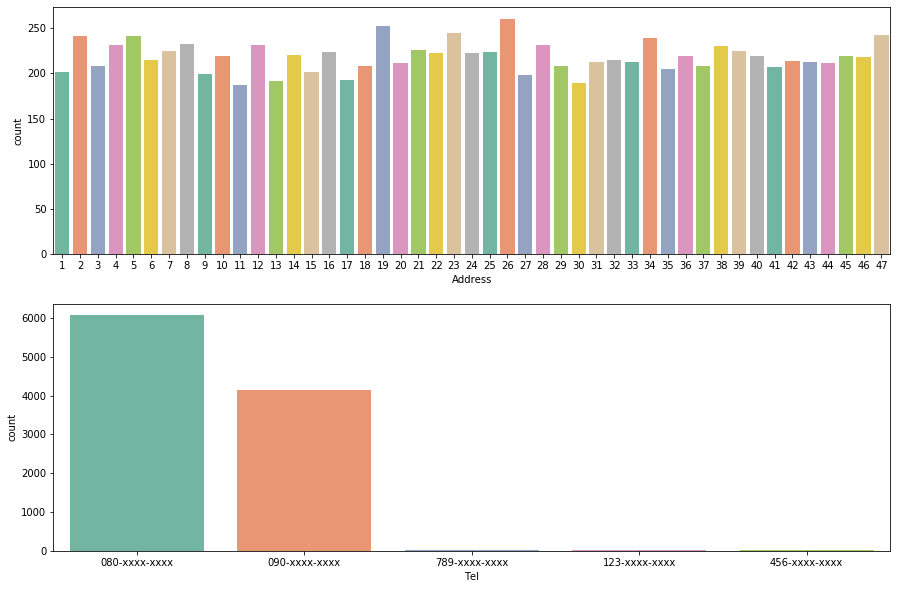

In [516]:
## ユーザデータの中身確認
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))


sns.countplot(x='Address',palette="Set2", data=user, ax=ax1);

sns.countplot(x='Tel',palette="Set2", data=user, ax=ax2);

## 未払いチェックリストデータ

In [517]:
unpaid = pd.read_csv('./data/Unpaid.csv')
unpaid['unpaid'] = 1
unpaid

,Transact-ID,unpaid
0,T00000223,1
1,T00000281,1
2,T00000475,1
3,T00000952,1
4,T00001506,1
...,...,...
86,T00015530,1
87,T00015569,1
88,T00015887,1
89,T00016282,1


## データのマージ

In [518]:
## トランザクション ← ユーザ情報
tran_user = pd.merge(tran, user, on='UserID', how="inner")
tran_user

,Transact-ID,UserID,MainItem,Price,Tel,Address
0,T00000001,U002136,FASHION-L,14420,080-xxxx-xxxx,6
1,T00000002,U001926,GOODS-L,19490,080-xxxx-xxxx,24
2,T00014842,U001926,GOODS-H,290770,080-xxxx-xxxx,24
3,T00015699,U001926,FASHION-L,13970,080-xxxx-xxxx,24
4,T00000003,U008955,FASHION-L,1900,080-xxxx-xxxx,26
...,...,...,...,...,...,...
16464,T00016443,U006179,FASHION-L,20200,080-xxxx-xxxx,17
16465,T00016445,U009913,FASHION-L,2190,090-xxxx-xxxx,35
16466,T00016448,U000418,FASHION-H,29550,090-xxxx-xxxx,7
16467,T00016465,U006825,FASHION-L,2580,090-xxxx-xxxx,21


In [519]:
## ← 未払いデータ
df = pd.merge(tran_user, unpaid, on='Transact-ID', how="outer").fillna(0)
df

,Transact-ID,UserID,MainItem,Price,Tel,Address,unpaid
0,T00000001,U002136,FASHION-L,14420,080-xxxx-xxxx,6,0.0
1,T00000002,U001926,GOODS-L,19490,080-xxxx-xxxx,24,0.0
2,T00014842,U001926,GOODS-H,290770,080-xxxx-xxxx,24,0.0
3,T00015699,U001926,FASHION-L,13970,080-xxxx-xxxx,24,0.0
4,T00000003,U008955,FASHION-L,1900,080-xxxx-xxxx,26,0.0
...,...,...,...,...,...,...,...
16464,T00016443,U006179,FASHION-L,20200,080-xxxx-xxxx,17,0.0
16465,T00016445,U009913,FASHION-L,2190,090-xxxx-xxxx,35,0.0
16466,T00016448,U000418,FASHION-H,29550,090-xxxx-xxxx,7,0.0
16467,T00016465,U006825,FASHION-L,2580,090-xxxx-xxxx,21,0.0


## はじめにデータの分析する

未払いのユーザ数（重複なし）：79人


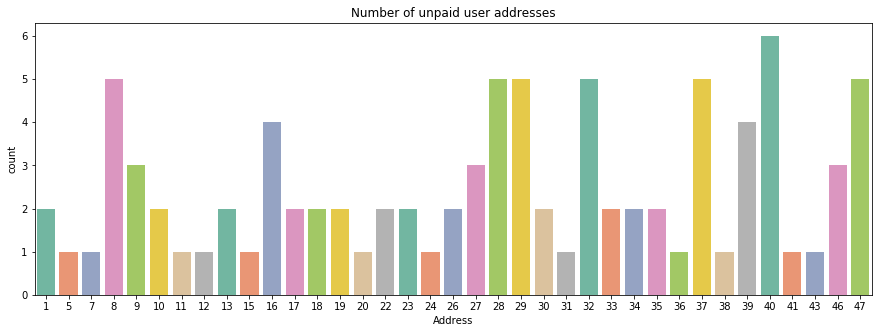

In [520]:
## 未払いのユーザに関しての分析

unpaid_user = df[df['unpaid'] == 1]

## 特定のユーザのみの未払いではないか？？
print("未払いのユーザ数（重複なし）：{}人".format(unpaid_user['UserID'].nunique()))

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(x="Address", palette='Set2', data=unpaid_user, ax=ax1).set_title('Number of unpaid user addresses');

In [521]:
### 未払いのユーザが常に未払いかどうか？？
unpaid_userID = unpaid_user['UserID']
unpaid_userID_lst = unpaid_userID.unique()

mask = df['UserID'].apply(lambda id: id in unpaid_userID_lst)
unpaid_user_df = df[mask]
unpaid_user_df

,Transact-ID,UserID,MainItem,Price,Tel,Address,unpaid
160,T00000064,U007890,FASHION-L,12520,789-xxxx-xxxx,17,0.0
161,T00002789,U007890,FASHION-L,2490,789-xxxx-xxxx,17,1.0
162,T00003207,U007890,FASHION-L,18820,789-xxxx-xxxx,17,1.0
163,T00007108,U007890,FASHION-H,15920,789-xxxx-xxxx,17,0.0
164,T00010046,U007890,FASHION-L,3120,789-xxxx-xxxx,17,0.0
...,...,...,...,...,...,...,...
15298,T00012488,U002262,FASHION-L,3090,090-xxxx-xxxx,47,1.0
15623,T00013382,U003710,FASHION-L,2000,080-xxxx-xxxx,18,1.0
15961,T00014442,U006599,FASHION-L,1850,789-xxxx-xxxx,23,1.0
15983,T00014521,U000180,FASHION-H,19460,789-xxxx-xxxx,37,1.0


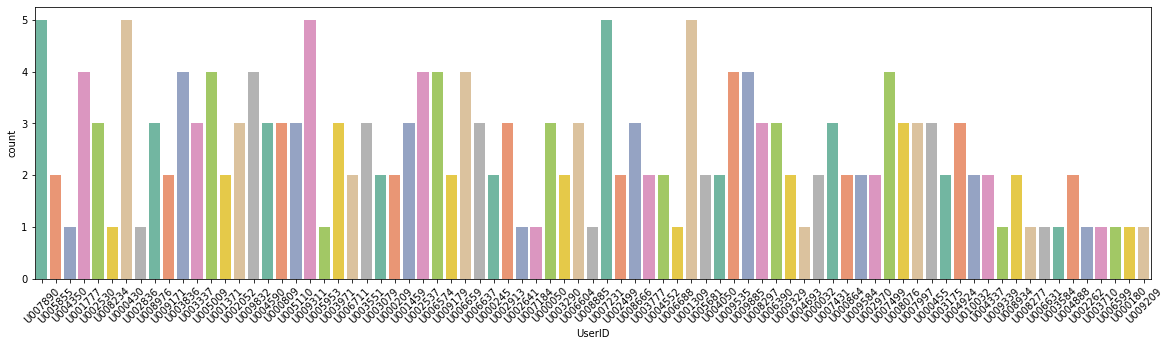

In [522]:
## 未払いユーザーの購入回数

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

chart = sns.countplot(x='UserID', palette='Set2', data=unpaid_user_df, ax=ax);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

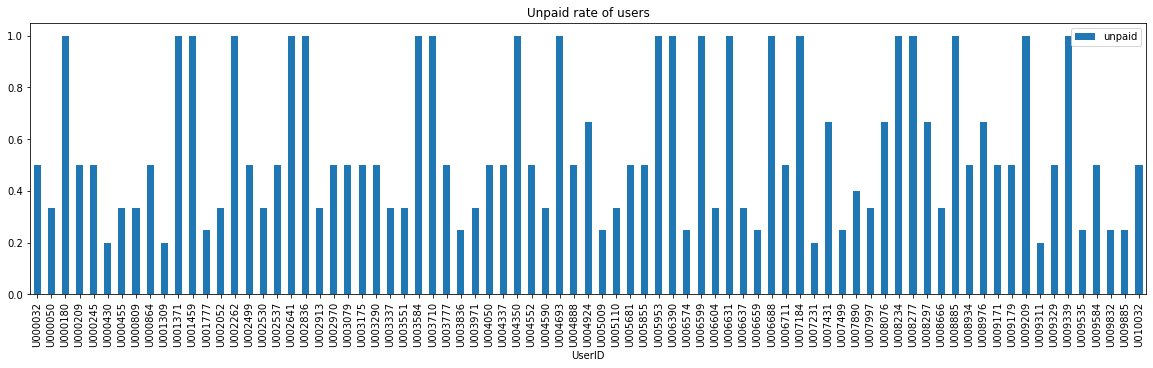

In [523]:
unpaid_user_buycheck = unpaid_user_df.groupby('UserID').mean()

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
unpaid_user_buycheck.plot(y=['unpaid'], kind='bar', ax=ax, title="Unpaid rate of users");

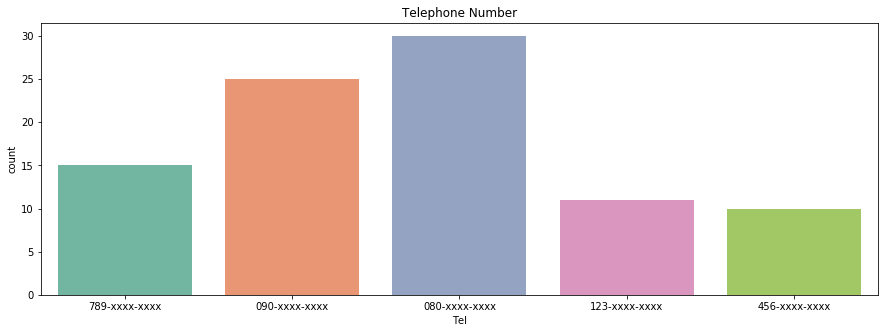

In [524]:
## 未払いユーザの電話番号

unpaid_user = df[df['unpaid'] == 1]


fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(x="Tel", palette='Set2', data=unpaid_user, ax=ax1).set_title('Telephone Number');

### 特徴
* ２回以上未払いを行うユーザ数は多い
<br>
<br>
→ しかしユーザIDを特徴量で入れてしまうと，今後ユーザIDのみで判断してしまう。これは新しいユーザに対しての効果が全くないため今回はユーザIDを特徴量に入れない。

<br>

* 全ての電話番号の分布に対して，未払いのユーザの電座番号は 123, 456, 789 の番号が多い
<br>
<br>
→ 123, 456, 789の番号は ダミーの電話番号として扱う

## 機械学習
全体の流れ

---
* データ自体の前処理を行う
* アンダーサンプリング・オーバーサンプリング の２パターン実装

以下，各アルゴリズムで機械学習を行う

---
* LogisticRegression
* DecisionTreeClassifier
* SupportVectorMachine

In [525]:
!pip install imblearn 

You should consider upgrading via the '/Users/Kaze/.pyenv/versions/3.7.4/bin/python3.7 -m pip install --upgrade pip' command.


In [526]:
## データ分割
from sklearn.model_selection import train_test_split

## アンダーサンプリング用ライブラリ
from imblearn.under_sampling import RandomUnderSampler

## オーバーサンプリング用ライブラリ
from imblearn.over_sampling import RandomOverSampler

## SMOTE おーバーサンプリング の中で特に使用される手法
## K近傍法のアルゴリズムを利用して少数派のサンプルを増やす方法
from imblearn.over_sampling import SMOTE

In [527]:
df.head(2)

,Transact-ID,UserID,MainItem,Price,Tel,Address,unpaid
0,T00000001,U002136,FASHION-L,14420,080-xxxx-xxxx,6,0.0
1,T00000002,U001926,GOODS-L,19490,080-xxxx-xxxx,24,0.0


## データ前処理
流れ

---
* アイテムカテゴリを one-hot encoding
* 住所カテゴリを one-hot-encoding
* <s>Price を　0 ~ 1　に正規化</s>
* 電話番号を one-hot encoding (123~789をダミーとして扱う）

* データを標準化

---
* User-IDを削除
* Transact-IDを削除

In [545]:
## アイテムカテゴリーをワンホットエンコーディング！

Item_dummy = pd.get_dummies(df['MainItem'])
Item_loc = df.columns.get_loc('MainItem')

new_df = df.copy(deep=True)

for i, col in enumerate(Item_dummy):
    new_df.insert(value=Item_dummy[col], column=col, loc=Item_loc+i)

new_df.drop('MainItem', axis=1, inplace=True)

new_df

,Transact-ID,UserID,FASHION-H,FASHION-L,GOODS-H,GOODS-L,Price,Tel,Address,unpaid
0,T00000001,U002136,0,1,0,0,14420,080-xxxx-xxxx,6,0.0
1,T00000002,U001926,0,0,0,1,19490,080-xxxx-xxxx,24,0.0
2,T00014842,U001926,0,0,1,0,290770,080-xxxx-xxxx,24,0.0
3,T00015699,U001926,0,1,0,0,13970,080-xxxx-xxxx,24,0.0
4,T00000003,U008955,0,1,0,0,1900,080-xxxx-xxxx,26,0.0
...,...,...,...,...,...,...,...,...,...,...
16464,T00016443,U006179,0,1,0,0,20200,080-xxxx-xxxx,17,0.0
16465,T00016445,U009913,0,1,0,0,2190,090-xxxx-xxxx,35,0.0
16466,T00016448,U000418,1,0,0,0,29550,090-xxxx-xxxx,7,0.0
16467,T00016465,U006825,0,1,0,0,2580,090-xxxx-xxxx,21,0.0


In [546]:
## 住所カテゴリーをワンホットエンコーディング！
## 住所は連続した数値じゃないため


Address_dummy = pd.get_dummies(new_df['Address'])
Address_loc = new_df.columns.get_loc('Address')

new_df2 = new_df.copy(deep=True)

for i, col in enumerate(Address_dummy):
    new_df2.insert(value=Address_dummy[col], column='Address'+str(col), loc=Address_loc+i)

new_df2.drop('Address', axis=1, inplace=True)

new_df2

,Transact-ID,UserID,FASHION-H,FASHION-L,GOODS-H,GOODS-L,Price,Tel,Address1,Address2,...,Address39,Address40,Address41,Address42,Address43,Address44,Address45,Address46,Address47,unpaid
0,T00000001,U002136,0,1,0,0,14420,080-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,T00000002,U001926,0,0,0,1,19490,080-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,T00014842,U001926,0,0,1,0,290770,080-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,T00015699,U001926,0,1,0,0,13970,080-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,T00000003,U008955,0,1,0,0,1900,080-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16464,T00016443,U006179,0,1,0,0,20200,080-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
16465,T00016445,U009913,0,1,0,0,2190,090-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
16466,T00016448,U000418,1,0,0,0,29550,090-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0
16467,T00016465,U006825,0,1,0,0,2580,090-xxxx-xxxx,0,0,...,0,0,0,0,0,0,0,0,0,0.0


#### データの正規化削除（後から全てに対しての標準化を行うため）

In [547]:
# ## 他のデータが 0~1 より Price を 0 ~ 1 に正規化する
# def normalize(x, amin=0, amax=1):
#     xmax = x.max()
#     xmin = x.min()
#     if xmin == xmax:
#         return np.ones_like(x)
#     return (amax - amin) * (x - xmin) / (xmax - xmin) + amin
# import numpy as np

# price = normalize(np.array(new_df2['Price']), amin=0, amax=1)

new_df3 = new_df2.copy(deep=True)
# new_df3['Price'] = price

# new_df3

In [548]:
## 電話番号をワンホットエンコーディング
## ここで 123, 456, 789はダミーとして同列に扱う

new_df4 = new_df3.copy(deep=True)

new_df4['Tel'] = new_df4['Tel'].apply(lambda tel: tel[0:3] if tel[0:3] in ["080", "090"] else 'dummy')
Tel_dummy = pd.get_dummies(new_df4['Tel'])
Tel_loc = new_df.columns.get_loc('Tel')



for i, col in enumerate(Tel_dummy):
    new_df4.insert(value=Tel_dummy[col], column='Tel '+str(col), loc=Tel_loc+i)

new_df4.drop('Tel', axis=1, inplace=True)

new_df4

,Transact-ID,UserID,FASHION-H,FASHION-L,GOODS-H,GOODS-L,Price,Tel 080,Tel 090,Tel dummy,...,Address39,Address40,Address41,Address42,Address43,Address44,Address45,Address46,Address47,unpaid
0,T00000001,U002136,0,1,0,0,14420,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,T00000002,U001926,0,0,0,1,19490,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,T00014842,U001926,0,0,1,0,290770,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,T00015699,U001926,0,1,0,0,13970,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,T00000003,U008955,0,1,0,0,1900,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16464,T00016443,U006179,0,1,0,0,20200,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
16465,T00016445,U009913,0,1,0,0,2190,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
16466,T00016448,U000418,1,0,0,0,29550,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
16467,T00016465,U006825,0,1,0,0,2580,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0


#### ユーザIDのone-hot encodingを削除　（今回はユーザIDを使用しないため）

In [549]:
# ## USERIDをワンホットエンコーディング
# new_df5 = new_df4.copy(deep=True)

# USERID_dummy = pd.get_dummies(new_df5['UserID'])
# USERID_loc = new_df5.columns.get_loc('UserID')



# for i, col in enumerate(USERID_dummy):
#     new_df5.insert(value=USERID_dummy[col], column=str(col), loc=USERID_loc+i)

# new_df5.drop('UserID', axis=1, inplace=True)

# new_df5

In [550]:
new_df4.describe()

,FASHION-H,FASHION-L,GOODS-H,GOODS-L,Price,Tel 080,Tel 090,Tel dummy,Address1,Address2,...,Address39,Address40,Address41,Address42,Address43,Address44,Address45,Address46,Address47,unpaid
count,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,...,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000,16469.000000
mean,0.117433,0.549699,0.029146,0.303722,17990.604773,0.592993,0.402332,0.004675,0.018763,0.021738,...,0.022041,0.019977,0.020220,0.020766,0.021191,0.021495,0.020584,0.021738,0.025077,0.005526
std,0.321945,0.497539,0.168220,0.459878,37176.143298,0.491291,0.490383,0.068219,0.135689,0.145831,...,0.146823,0.139925,0.140756,0.142605,0.144026,0.145032,0.141992,0.145831,0.156365,0.074131
min,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2350.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,4580.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,20310.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,535280.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [551]:
## 説明変数と目的変数
columnList = new_df4.columns.to_list()
columnList.remove('Transact-ID')
# columnList.remove('Tel')
columnList.remove('UserID')
columnList.remove('unpaid')
x = pd.DataFrame( new_df4.loc[:, columnList])
y = pd.DataFrame( new_df4.loc[:, ['unpaid']])

## 訓練用 : 検証用 = 7 : 3
(X_train, X_test, y_train, y_test ) = train_test_split(x, y, test_size = 0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11528, 55)
(11528, 1)
(4941, 55)
(4941, 1)


In [552]:
# 説明変数を標準化（平均0、標準偏差1となるように変数変換）する

# データの標準化を行うためのモジュールをインポート
from sklearn.preprocessing import StandardScaler

def standard(X_train, X_test):
    sclr_X = StandardScaler()
    sclr_X.fit(X_train)
    X_train = sclr_X.transform(X_train)
    X_test = sclr_X.transform(X_test)
    
    return X_train, X_test

X_train, X_test = standard(X_train, X_test)

In [553]:
X_train

array([[-0.35836573, -1.10701519, -0.17485403, ..., -0.14487984,
        -0.14827615, -0.16064029],
       [-0.35836573,  0.90332997, -0.17485403, ..., -0.14487984,
        -0.14827615, -0.16064029],
       [-0.35836573,  0.90332997, -0.17485403, ..., -0.14487984,
        -0.14827615, -0.16064029],
       ...,
       [-0.35836573,  0.90332997, -0.17485403, ..., -0.14487984,
        -0.14827615, -0.16064029],
       [-0.35836573,  0.90332997, -0.17485403, ..., -0.14487984,
        -0.14827615, -0.16064029],
       [-0.35836573,  0.90332997, -0.17485403, ..., -0.14487984,
        -0.14827615, -0.16064029]])

## アンダーサンプリング

In [554]:

# 正例の数
positive_count_train = int(y_train['unpaid'].sum())
print('正例の数：', positive_count_train)

# 正例が20％になるまで負例をアンダーサンプリング
rus = RandomUnderSampler({0:positive_count_train*4, 1:positive_count_train}, random_state=1234)
print(rus)

# 学習データに反映
under_X_train_rs, under_y_train_rs = rus.fit_sample(X_train, y_train)
under_X_train_rs = pd.DataFrame(under_X_train_rs, columns=columnList)
under_y_train_rs = pd.DataFrame(under_y_train_rs, columns=["unpaid"])

## サンプリング結果を表示
print( "-----------------------------------------------------" )
print( "サンプリング前の説明変数の数と件数：" + str(X_train.shape) )
print( "サンプリング後の説明変数の数と件数：" + str(under_X_train_rs.shape) )
print( "-----------------------------------------------------" )
print( "サンプリング前の目的変数の数と件数：" + str(y_train.shape) )
print( "サンプリング後の目的変数の数と件数：" + str(under_y_train_rs.shape) )
print( "-----------------------------------------------------" )
print( "サンプリング前の目的変数＝ 0 の件数：" + str(int(y_train.shape[0] - y_train.sum()) ))
print( "サンプリング後の目的変数＝ 0 の件数：" + str(int(under_y_train_rs.shape[0] - under_y_train_rs.sum()) ))
print( "-----------------------------------------------------" )
print( "サンプリング前の目的変数＝ 1 の件数：" + str(int(y_train.sum()) ))
print( "サンプリング後の目的変数＝ 1 の件数：" + str(int(under_y_train_rs.sum()) ))
print( "-----------------------------------------------------" )

正例の数： 65
RandomUnderSampler(random_state=1234, sampling_strategy={0: 260, 1: 65})
-----------------------------------------------------
サンプリング前の説明変数の数と件数：(11528, 55)
サンプリング後の説明変数の数と件数：(325, 55)
-----------------------------------------------------
サンプリング前の目的変数の数と件数：(11528, 1)
サンプリング後の目的変数の数と件数：(325, 1)
-----------------------------------------------------
サンプリング前の目的変数＝ 0 の件数：11463
サンプリング後の目的変数＝ 0 の件数：260
-----------------------------------------------------
サンプリング前の目的変数＝ 1 の件数：65
サンプリング後の目的変数＝ 1 の件数：65
-----------------------------------------------------


## オーバーサンプリング

In [555]:
# 負例の数
negative_count_train = int( y_train.count() - y_train['unpaid'].sum())
print('負例の数：', negative_count_train)

# 正例が20％になるまで正例をオーバーサンプリング 
ros = RandomOverSampler({0:negative_count_train, 1:int(negative_count_train*0.2)}, random_state=1234)
print(ros)

# 学習データに反映
over_X_train_rs, over_y_train_rs = ros.fit_sample(X_train, y_train)
over_X_train_rs = pd.DataFrame(over_X_train_rs, columns=columnList)
over_y_train_rs = pd.DataFrame(over_y_train_rs, columns=["unpaid"])

## サンプリング結果を表示
print( "-----------------------------------------------------" )
print( "サンプリング前の説明変数の数と件数：" + str(X_train.shape) )
print( "サンプリング後の説明変数の数と件数：" + str(over_X_train_rs.shape) )
print( "-----------------------------------------------------" )
print( "サンプリング前の目的変数の数と件数：" + str(y_train.shape) )
print( "サンプリング後の目的変数の数と件数：" + str(over_y_train_rs.shape) )
print( "-----------------------------------------------------" )
print( "サンプリング前の目的変数＝ 0 の件数：" + str(int(y_train.shape[0] - y_train.sum()) ))
print( "サンプリング後の目的変数＝ 0 の件数：" + str(int(over_y_train_rs.shape[0] - over_y_train_rs.sum()) ))
print( "-----------------------------------------------------" )
print( "サンプリング前の目的変数＝ 1 の件数：" + str(int(y_train.sum()) ))
print( "サンプリング後の目的変数＝ 1 の件数：" + str(int(over_y_train_rs.sum()) ))
print( "-----------------------------------------------------" )

負例の数： 11463
RandomOverSampler(random_state=1234, sampling_strategy={0: 11463, 1: 2292})
-----------------------------------------------------
サンプリング前の説明変数の数と件数：(11528, 55)
サンプリング後の説明変数の数と件数：(13755, 55)
-----------------------------------------------------
サンプリング前の目的変数の数と件数：(11528, 1)
サンプリング後の目的変数の数と件数：(13755, 1)
-----------------------------------------------------
サンプリング前の目的変数＝ 0 の件数：11463
サンプリング後の目的変数＝ 0 の件数：11463
-----------------------------------------------------
サンプリング前の目的変数＝ 1 の件数：65
サンプリング後の目的変数＝ 1 の件数：2292
-----------------------------------------------------


## グラフ化・精度評価の関数作成

---
### FPR: Flase Positive Rate
実際に正しくないもののうち, 何%間違ったか

### TPR (Precision) : True Positive Rate
正しいと予測したもののうち本当に正しいものの割合　（偽陽性を低く抑えたいときに）

### ROC curve
横軸が偽陽性率，縦軸が敏感度でプロットしたもの<br>
普通偽陽性が上がると真陽性が上がる（全て真と言えばいい）ので，偽陽性が低いときに真陽性が１に近づくのが理想

### AUC
ROC曲線の積分値　理想は1

---

In [563]:
# ロジスティック回帰をインポート
from sklearn.linear_model import LogisticRegression

# 決定木構築用クラスをインポート
from sklearn.tree import DecisionTreeClassifier

# 決定木可視化用モジュール群をインポート
from sklearn.tree import export_graphviz

# サポートベクターマシンを行うためのモジュールをインポート
from sklearn.svm import SVC


## 正解率
from sklearn.metrics import accuracy_score
## 混合行列を作成するためのモジュール
from sklearn.metrics import confusion_matrix
## ROCを作成
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [564]:
from IPython.display import display

def Calc_and_graph(clf, X_train_rs, y_train_rs):
    print("\n====== 精度検証を行う (訓練用データを確認) =====\n")
    print(accuracy_score(y_train_rs, clf.predict(X_train_rs)))
    conf_mtrx_df = pd.DataFrame(confusion_matrix(y_train_rs, clf.predict(X_train_rs).reshape(-1, 1)))
    conf_mtrx_df.rename(columns={0: 'predict(0)', 1: 'predict(1)'}, index={0: 'target(0)', 1: 'target(1)'}, inplace=True)
    display(conf_mtrx_df)
    
    print("\n===== 精度検証を行う（検証用データを確認） =====\n")
    print(accuracy_score(y_test, clf.predict(X_test)))
    conf_mtrx_df = pd.DataFrame(confusion_matrix(y_test,clf.predict(X_test).reshape(-1,1)))
    conf_mtrx_df.rename(columns={0: 'predict(0)',1: 'predict(1)'}, index={0: 'target(0)',1: 'target(1)'}, inplace=True)
    display(conf_mtrx_df)
    
    
    print("\n===== 精度検証を行う =====\n")

    print("< 訓練用データについて >")
    print("FPR、TPR、（閾値）、AUCを算出")
    y_train_predict = clf.predict_proba(X_train_rs)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_predict)
    auc_value_train = auc(fpr_train, tpr_train)
    # ROC曲線をプロット
    plt.plot(fpr_train, tpr_train, label='ROC curve (area = %.2f)'%auc_value_train)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    print("AUC(train): "+str(auc_value_train))

    print("\n< 検証用データについて >")
    print("FPR、TPR、（閾値）、AUCを算出")
    y_test_predict = clf.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)
    auc_value_test = auc(fpr_test, tpr_test)
    # ROC曲線をプロット
    plt.plot(fpr_test, tpr_test, label='ROC curve (area = %.2f)'%auc_value_test)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    print("AUC(test): "+str(auc_value_test))
    print("AUC ratio(train/test): "+str(auc_value_train/auc_value_test))


## ロジスティック回帰

ロジスティック回帰モデルをつくります。
ロジスティック回帰モデルを作成するときは、以下のパラメータを（一部でいいので）設定する必要があります。
*   fit_intercept：切片を入れるか？
*   penalty：正則化の方法を指定するパラメータ l1 か l2 を指定。（Lassoを実施する際はL1正則化項を入れたいのでl1を指定する）
*   solver：Lasso回帰を実施する際は 'liblinear' を指定する必要がある。（計算をする際に「ソルバー」という機能が必要なのですが、デフォルトのソルバーはL2用なので変更してあげる必要があります。）
*   C：正則化の強さを指定するパラメータ。正の値を指定する（デフォルト値は1.0）。Cの値が小さいほど、強く正則化する。

モデルは訓練用データで構築します（X_train_rs_std、y_train_rs）

#### アンダーサンプリング


====== 精度検証を行う (訓練用データを確認) =====

0.9261538461538461


,predict(0),predict(1)
target(0),257,3
target(1),21,44



===== 精度検証を行う（検証用データを確認） =====

0.9914996964177292


,predict(0),predict(1)
target(0),4886,29
target(1),13,13



===== 精度検証を行う =====

< 訓練用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(train): 0.9355029585798816

< 検証用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(test): 0.8024767196181235
AUC ratio(train/test): 1.1657695926992893


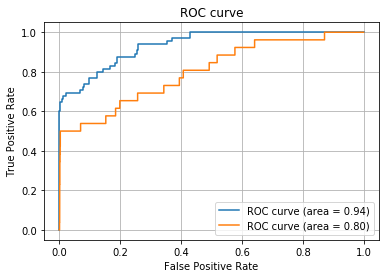

In [565]:
## ロジスティック回帰分析を実施
clf = LogisticRegression(C=1000)
clf.fit(under_X_train_rs, under_y_train_rs)
Calc_and_graph(clf, under_X_train_rs, under_y_train_rs)

#### オーバーサンプリング


====== 精度検証を行う (訓練用データを確認) =====

0.9366775717920756


,predict(0),predict(1)
target(0),11388,75
target(1),796,1496



===== 精度検証を行う（検証用データを確認） =====

0.9917020845982595


,predict(0),predict(1)
target(0),4887,28
target(1),13,13



===== 精度検証を行う =====

< 訓練用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(train): 0.9330391323537495

< 検証用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(test): 0.7749158776117067
AUC ratio(train/test): 1.2040521549634255


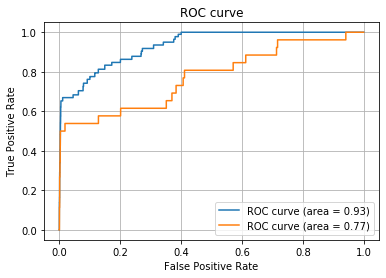

In [566]:
## ロジスティック回帰分析を実施
clf = LogisticRegression(C=1000)
clf.fit(over_X_train_rs, over_y_train_rs)
Calc_and_graph(clf, over_X_train_rs, over_y_train_rs)

## Decision Tree Classifier

決定木モデルをつくります。
決定木モデルを作成するときは、以下のパラメータを（一部でいいので）設定する必要があります。
*   class_weight：予測するクラスに対して重要度の重みを付ける場合に使う引数ですが、原則 None（重みは平等）で結構です。
*   criterion：分割を決定するのに用いる不純度を決めます。'gini'ならばジニ係数、'entropy'ならばエントロピーを不純度として用います。
*   max_depth：木の最大深さを決めます。Noneの場合は全ての葉が純粋（単独クラス）になるまで木が成長します。（他のパラメータによって停止される可能性はある）
*   max_features：使用する変数の数の上限を決めます。
*   max_leaf_nodes：最大の葉の数をきめます。ここで指定した葉の数以内で、もっともcriterionが低くなるように木が成長します。
*   min_impurity_decrease：ここで設定した値以上のcriterionの減少を引き起こす場合のみ、ノードは分割されるようになります。（criterionの減少に効果的ではない分割が発生しないようになります。）
*   min_impurity_split：使われなくなった引数です。原則、設定しません。（Scikit-learn 0.19以降）
*   min_samples_leaf：１つの葉に必要なサンプルの最小数。ここで指定するよりも小さなサンプル数になってしまう葉は生成させません。
*   min_samples_split：ノードを分割するために必要なサンプルの最小数。ここで指定するよりも小さなサンプル数のノードは分割されません。
*   min_weight_fraction_leaf：葉に必要な（すべての入力サンプルの）重みの合計の最小加重部分。原則、設定不要です。
*   presort：分割の閾値の発見を早めるためにデータを事前にソートしておくかを決めますが、大きいデータだとソートに時間がかかるため、かえって速度が遅くなる可能性もあります。原則、設定不要です。
*   random_state：分割の閾値を決めるときに乱数をしようする場合があり、その際のシードの値を入力します。（値を定めておくと処理の再現性が得られます）
*   splitter：分割の閾値を決める場合に使うアルゴリズムを選択します。原則、設定不要です。

モデルは訓練用データで構築します（X_train_rs_std、y_train_rs）。

#### アンダーサンプリング


====== 精度検証を行う (訓練用データを確認) =====

0.9415384615384615


,predict(0),predict(1)
target(0),259,1
target(1),18,47



===== 精度検証を行う（検証用データを確認） =====

0.9577008702691763


,predict(0),predict(1)
target(0),4717,198
target(1),11,15



===== 精度検証を行う =====

< 訓練用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(train): 0.8781656804733727

< 検証用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(test): 0.7843962751388998
AUC ratio(train/test): 1.11954340976169


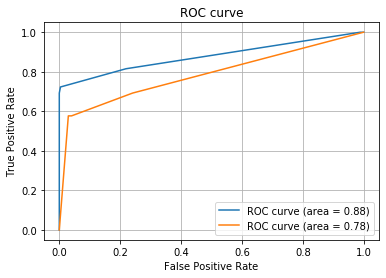

In [567]:
# 決定木分析を実施し、判別モデルを構築する
clf = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=10, random_state=1234)
clf.fit(under_X_train_rs,under_y_train_rs)
Calc_and_graph(clf, under_X_train_rs, under_y_train_rs)

#### オーバーサンプリング


====== 精度検証を行う (訓練用データを確認) =====

0.9440203562340967


,predict(0),predict(1)
target(0),11354,109
target(1),661,1631



===== 精度検証を行う（検証用データを確認） =====

0.9884638737097754


,predict(0),predict(1)
target(0),4869,46
target(1),11,15



===== 精度検証を行う =====

< 訓練用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(train): 0.8571197999664754

< 検証用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(test): 0.7913803897018546
AUC ratio(train/test): 1.083069294008394


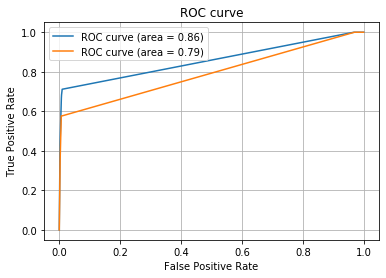

In [568]:
# 決定木分析を実施し、判別モデルを構築する
clf = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=10, random_state=1234)
clf.fit(over_X_train_rs,over_y_train_rs)
Calc_and_graph(clf, over_X_train_rs, over_y_train_rs)

## サポートベクターマシーン

SVMで線形判別モデルをつくります。
SVMでモデルを作成するときは、以下のパラメータを（一部でいいので）設定する必要があります。
*   C：ソフトマージンの厳しさを表すパラメータ（デフォルト1.0、データ解析者が決めるハイパーパラメータ）
*   kernel：カーネル関数を指定する（カーネルトリックを使わない際は linear、使う際は rbf などを指定する）
*   gamma：カーネルトリックを使う際のパラメータ（、データ解析者が決めるハイパーパラメータ）
*   probability：確率をアウトプットする際はTrueにする。（デフォルトFalse）

モデルは訓練用データで構築します（X_train_rs_std、y_train_rs）。

#### アンダーサンプリング


====== 精度検証を行う (訓練用データを確認) =====

0.9323076923076923


,predict(0),predict(1)
target(0),260,0
target(1),22,43



===== 精度検証を行う（検証用データを確認） =====

0.9908925318761385


,predict(0),predict(1)
target(0),4881,34
target(1),11,15



===== 精度検証を行う =====

< 訓練用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(train): 0.9350887573964496

< 検証用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(test): 0.81527114797715
AUC ratio(train/test): 1.1469665763551071


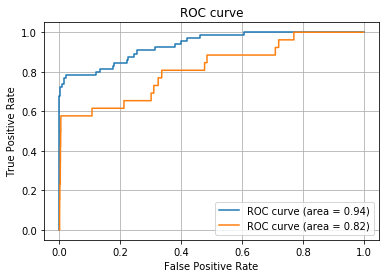

In [569]:
# SVMを実施し、判別モデルを構築する
clf = SVC(C=10, kernel='rbf', gamma=0.005, probability=True, random_state=5678)
clf.fit(under_X_train_rs, under_y_train_rs)
Calc_and_graph(clf, under_X_train_rs, under_y_train_rs)

#### オーバーサンプリング


====== 精度検証を行う (訓練用データを確認) =====

0.9451835696110505


,predict(0),predict(1)
target(0),11375,88
target(1),666,1626



===== 精度検証を行う（検証用データを確認） =====

0.9874519328071241


,predict(0),predict(1)
target(0),4870,45
target(1),17,9



===== 精度検証を行う =====

< 訓練用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(train): 0.9859843849983077

< 検証用データについて >
FPR、TPR、（閾値）、AUCを算出
AUC(test): 0.7580053212301432
AUC ratio(train/test): 1.300761824993767


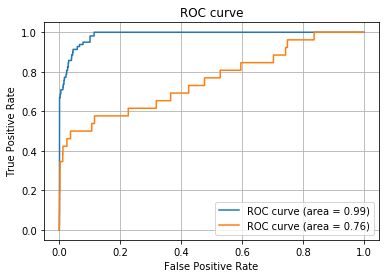

In [570]:
# SVMを実施し、判別モデルを構築する
clf = SVC(C=10, kernel='rbf', gamma=0.005, probability=True, random_state=5678)
clf.fit(over_X_train_rs, over_y_train_rs)
Calc_and_graph(clf, over_X_train_rs, over_y_train_rs)

# まとめ

以下のデータから未払い予想を行うことができた
* 住所データ
* 購入額データ
* 購入アイテムカテゴリデータ
* 電話番号データ

---
#### 前処理として以下の２パターンを行った
1. 正例が20%になるように負例をアンダーサンプリング
2. 正例が20%になるように正例をオーバーサンプリング

---
#### 学習モデルとして以下の３パターンを適用した
1. LogisticRegression
2. DecisionTreeClassifier
3. SupportVectorMachine

#### 予想を行った結果
※ 未払いを行う人．つまり今回予想すべき人を１（正例）としている

[ 結果：**DecisionTreeClassifierのオーバーサンプリングにて最もよい精度・AUC ration の値を出すことができた** ]
<br>
(実際の値は上の精度グラフなどを参照）

<br>

また，どの学習においても90%以上の精度を得ることができたが，検証データを見ると精度が高くなったのは，やはり正例が少ないことが理由だと考えられる。
実際に検証データにおいて，正例を正しく正例と判別できたのは５０％ほどであった。<br>


<br>

分析より，未払いを行うユーザは何度も，複数回未払いをすることがあるため <br>
ユーザIDを学習に使用するとより精度を向上することができると考えられる．<br>
しかしこの場合．ユーザそれぞれで固有のユーザIDで判断してしまうため，新しいユーザに対しての効果がかなり薄くなってしまう．<br>
よって今回はこの指標を使用していない．
